# Libraries

In [1]:
# Data-handling libraries
import pandas as pd

# Text-handling libraries
from nltk.text import Text, TextCollection
from nltk.tokenize import RegexpTokenizer
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords

# Other imports
import re
import matplotlib.pyplot as plt

# Data Import

In [2]:
# Data source: http://menus.nypl.org/data
menu = pd.read_csv("data/Menu.csv.bz2")
dish = pd.read_csv("data/Dish.csv.bz2")
menu_item = pd.read_csv("data/MenuItem.csv.bz2")
menu_page = pd.read_csv("data/MenuPage.csv.bz2")

# Data Cleaning

## Shape data

In [3]:
# Add menu id to each menu item
df = pd.merge(
    menu_item[["dish_id", "menu_page_id"]],
    menu_page[["id", "menu_id"]],
    how = "right",
    left_on = "menu_page_id",
    right_on = "id"
)

# Add menu date to each menu id
df = pd.merge(
    df,
    menu[["id", "date"]],
    how = "right",
    left_on = "menu_id",
    right_on = "id"
)

# Add dish name to each menu item
df = pd.merge(
    df,
    dish[["id", "name"]],
    how = "right",
    left_on = "dish_id",
    right_on = "id"
)

# Remove intermediate columns
df = df[["name", "date", "menu_id"]]

# Delete our original imports to free up memory
del menu
del dish
del menu_item
del menu_page

In [4]:
# Drop malformed dates
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [5]:
# Drop 68438 unknown and 638 malformed dates (≈ 5%)
df.dropna(inplace=True)

In [6]:
# Calculate year and decade
df["year"] = pd.DatetimeIndex(df["date"]).year
df["decade"] = df["year"] // 10 * 10

## Replace special characters

In [7]:
# Fractions
df["name"] = df["name"].str.replace("[½]", '1/2')

# Curly quotes
df["name"] = df["name"].str.replace("[“”„]", '"')

# Letters with diacricics
# df["name"] = df["name"].str.replace("[Ää]",   "ae")
# df["name"] = df["name"].str.replace("[Éèéê]", "e")
# df["name"] = df["name"].str.replace("[Îï]",   "i")
# df["name"] = df["name"].str.replace("[Öö]",   "oe")
# df["name"] = df["name"].str.replace("[Ü]",    "ue")
# df["name"] = df["name"].str.replace("[ß]",    "ss")
# df["name"] = df["name"].str.replace("[àáâå]", "a")
# df["name"] = df["name"].str.replace("[ç]",    "c")
# df["name"] = df["name"].str.replace("[óø]",   "o")
# df["name"] = df["name"].str.replace("[û]",    "u")
# df["name"] = df["name"].str.replace("[Œœ]",   "oe")
# df["name"] = df["name"].str.replace("[Śś]",   "s")
# df["name"] = df["name"].str.replace("[ź]",    "z")

In [8]:
# Foreign scripts can be REALLY hard to work with, so we drop them

# Greek
df = df[~df["name"].str.contains("[ΑΓΔΕΖΘΙΚΛΜΝΟΠΣΤΥΧΨΩάίαγδεηθιλνξοπρςστυχωϊό]")]

# Devanagari
df = df[~df["name"].str.contains("[ईककीकोखगीचचाचेजजिणतताथथॅददादुदूननंनानीनूपपाबाबीभोमैररीललालीलूलेळवाशीशुससीसोहिं१२३४७]")]

# Han
df = df[~df["name"].str.contains("[丁三上串五什仁保公冬包半卷司吐吞哲大夫子宫尾巴廣手抄拌排春景會木東松果栗檬檸水油洋海涼清湯火炒炸烤煙燒爆片牛玉瓜白磨竹米紅素紫絲绦翅肉肚腐腰腿芥花茸菇菜蔴蘭蛋蝦西豆貼賓辣酸醉醬鍋雙雞雲青須餃香骨魚鮑鮮鳳鴨鷄鹹麵]")]

In [9]:
# Confirm that we got all non-ASCII characters
# df[df["name"].str.contains("[^\x00-\x7F]")]

## Tokenize etc.

In [10]:
def cleanText(text):
    tok = RegexpTokenizer("[a-z'-]+")
    return " ".join(tok.tokenize(text.lower()))

df["name"] = df["name"].apply(cleanText)

# Drop any names that got removed completely
df = df[df["name"] != ""]

## Write out cleaned data

In [11]:
df.drop(columns="date").to_csv("data/Dishes-by-year.csv.bz2", compression="bz2", index=False)

# EDA

In [12]:
# For histogram bins
decades = range(1850, 2030, 10)
size = (10, 5)

## Dates

In [ ]:
plt.title("Menus by decade")
df.groupby("menu_id")["year"].hist(figsize=size, bins=decades); # 18 decades are represented

KeyboardInterrupt: 

## Menus

In [ ]:
plt.title("Menu length distribution")
df.groupby("menu_id").sum().hist()

## Dishes

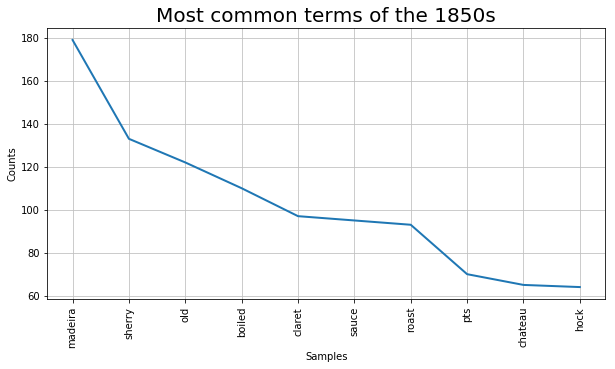

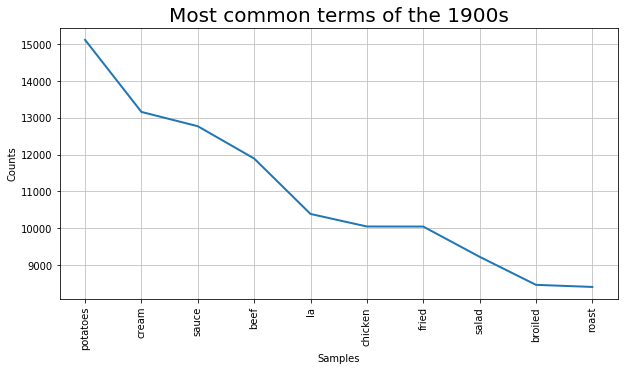

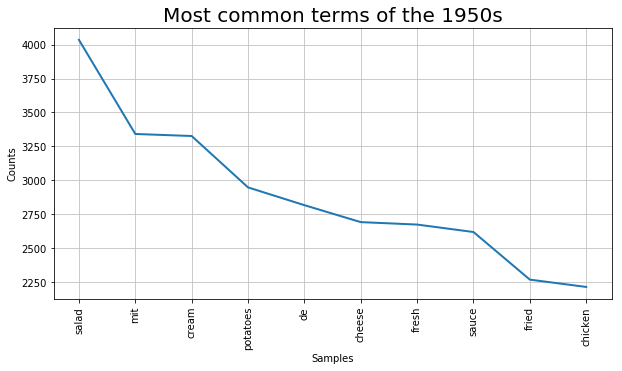

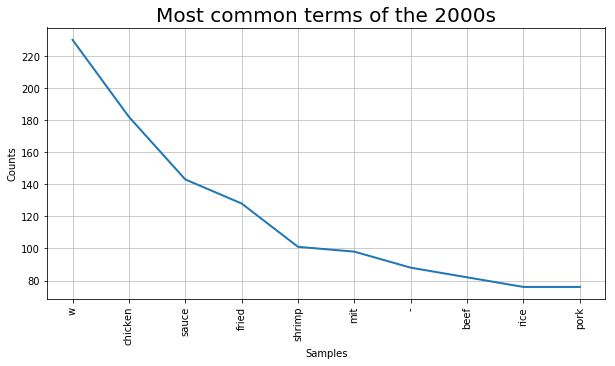

In [15]:
for decade in [1850, 1900, 1950, 2000]:
    words = [[word] for text in df[df["decade"]==decade]["name"].str.split() for word in text
                  if word not in stopwords.words("english")]
    plt.figure(figsize=size)
    plt.title(f"Most common terms of the {decade}s", size=20)
    FreqDist(TextCollection(words)).plot(10);

In [ ]:
for term in ["chicken", "coffee", "tea", "tomato", "vanilla", "chocolate", "jell-?o", "cod", "soy", "tofu", "boiled", "reduction", "marinated", "fricass[eé]e", "sauce"]:
    # We want proportions of menus since we have many more from some decades than from others (see above hist)
    
    # Proportion of ITEMS
    # prop = df[df["name"].str.contains(term)].groupby("decade").sum() / df.groupby("decade").sum()
    
    # Proportion of MENUS
    prop = df[df["name"].str.contains(term)].groupby("decade").count()["menu_id"] / df.groupby("decade").count()["menu_id"]
    
    plt.figure(figsize=size)
    plt.title(term, fontsize=20)
    plt.xticks(decades)
    plt.xlim((1850, 2020))
    plt.plot(prop)
    #display(df.groupby("decade").sum())

In [ ]:
def tfidf(corpus, text, term):
    tf = np.sum(text == name)
    idf = np.log()
    return tf * idf

tfidf(
    corpus = df["name"],
    text = df[df["decade"]==1960],
    term = "chicken"
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit_transform(df["name"])


In [ ]:
tfidf.vocabulary_

In [ ]:
list()